<a href="https://colab.research.google.com/github/jung-un/rl_toss_ad_optimization/blob/main/Toss_Data_preprocessing_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##데이터 불러오기

In [ ]:
!pip install scikit-learn==1.3.2

In [1]:
# 1. 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


##전처리


In [4]:

import numpy as np
import pandas as pd
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

# -------------------------
# 설정
# -------------------------
PATH  = "/content/drive/MyDrive/rl_toss_ad_optimization/sampled_500k_stratified.csv"
df = pd.read_csv(PATH).reset_index(drop=True)

# -------------------------
# 1) 로드 & 기본 정리
# -------------------------
if "clicked" in df.columns and "reward" not in df.columns:
    df = df.rename(columns={"clicked": "reward"})
assert "reward" in df.columns, "reward(또는 clicked) 컬럼이 필요합니다."
df = df[df["reward"].isin([0, 1])].copy()

# 존재할 때만 간단 도메인 필터
if "hour" in df:        df = df[df["hour"].between(0, 23)]
if "day_of_week" in df: df = df[df["day_of_week"].between(1, 7)]
if "age_group" in df:   df = df[df["age_group"].between(1, 10)]
df = df.reset_index(drop=True)

# -------------------------
# 2) l_feat_* → ad_contents (K=8)
# -------------------------
lcols = [c for c in df.columns if c.startswith("l_feat_")]
assert len(lcols) > 0, "l_feat_* 컬럼이 필요합니다."

# 수치화 + 비유효 행 제거
X = df[lcols].apply(pd.to_numeric, errors="coerce")
mask_valid = np.isfinite(X).all(axis=1)
df = df.loc[mask_valid].reset_index(drop=True)
X = df[lcols].astype(float)

# 표준화 + KMeans
K = 8
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
df["ad_contents"] = kmeans.fit_predict(X_std).astype(int)

# 군집에 사용한 l_feat_*는 누출 방지 차원에서 제거
df.drop(columns=lcols, inplace=True)

# -------------------------
# 3) seq 파생(필수 3개: last/len/entropy)
# -------------------------
def parse_seq(s):
    if pd.isna(s):
        return []
    out = []
    for t in str(s).split(","):
        t = t.strip()
        if not t:
            continue
        try:
            out.append(int(t))
        except:
            continue
    return out

def shannon_entropy(lst):
    if not lst:
        return 0.0
    from math import log
    cnt = Counter(lst); n = len(lst)
    return -sum((c/n) * log((c/n) + 1e-12) for c in cnt.values())

seq_list = df["seq"].apply(parse_seq) if "seq" in df.columns else pd.Series([[]]*len(df))
df["seq_last"]     = seq_list.apply(lambda x: x[-1] if x else -1)
df["seq_len"]      = seq_list.str.len()
df["seq_entropy"]  = seq_list.apply(shannon_entropy)

# 원본 seq는 보존/삭제 선택 가능 (여기선 삭제)
if "seq" in df.columns:
    df.drop(columns=["seq"], inplace=True)

# -------------------------
# 4) 불필요 컬럼 일괄 제거 (feat_a~e, history_a, history_b 등)
# -------------------------
drop_prefixes = ["feat_a_", "feat_b_", "feat_c_", "feat_d_", "feat_e_", "history_a_", "history_b_"]
drop_cols = []
for p in drop_prefixes:
    drop_cols += [c for c in df.columns if c.startswith(p)]
if drop_cols:
    df.drop(columns=drop_cols, inplace=True)

# -------------------------
# 5) 최종 화이트리스트만 유지
# -------------------------
keep_cols = [
    # 컨텍스트(있으면 유지)
    "gender", "age_group", "inventory_id", "day_of_week", "hour",
    # seq 최소 3개
    "seq_last", "seq_len", "seq_entropy",
    # 팔/보상
    "ad_contents", "reward"
]
keep_cols = [c for c in keep_cols if c in df.columns]
df = df[keep_cols].copy()

# -------------------------
# 6) 간단 검증 출력
# -------------------------
print("최종 컬럼:", df.columns.tolist(), "| 개수:", len(df.columns))
print(df.head(3))

# 팔별 CTR(시뮬레이터 p_dist 계산용 참고)
arm_table = (df.groupby("ad_contents")["reward"]
               .agg(ctr="mean", n="count")
               .reset_index()
               .sort_values("ad_contents"))
print("\n[ad_contents별 CTR/표본수]\n", arm_table.head(10))



최종 컬럼: ['gender', 'age_group', 'inventory_id', 'day_of_week', 'hour', 'seq_last', 'seq_len', 'seq_entropy', 'ad_contents', 'reward'] | 개수: 10
   gender  age_group  inventory_id  day_of_week  hour  seq_last  seq_len  \
0     2.0        6.0            43            4    19        35     1237   
1     1.0        7.0             2            7    18        35     1660   
2     2.0        8.0            29            7    17        35      464   

   seq_entropy  ad_contents  reward  
0     3.527355            5       1  
1     3.454312            1       1  
2     3.536106            4       1  

[ad_contents별 CTR/표본수]
    ad_contents       ctr       n
0            0  0.270495  103695
1            1  0.299013   50272
2            2  0.273402   37176
3            3  0.364290    3198
4            4  0.324849  102429
5            5  0.232954   27997
6            6  0.206464   31497
7            7  0.343763  142514


In [ ]:
import os

# 1) 최종 컬럼 화이트리스트
keep_cols = [
    "gender", "age_group", "inventory_id", "day_of_week", "hour",
    "seq_last", "seq_len", "seq_entropy",
    "ad_contents", "reward"
]
keep_cols = [c for c in keep_cols if c in df.columns]   # 존재하는 것만
assert {"ad_contents","reward"}.issubset(keep_cols), "핵심 컬럼 누락(ad_contents/reward)"

df_ext = df[keep_cols].copy()

# 2) 저장 경로
OUTDIR = "/content/drive/MyDrive"
os.makedirs(OUTDIR, exist_ok=True)
SAVE_PATH = os.path.join(OUTDIR, "Toss_preprocessed_FF.csv")

# 3) 저장
df_ext.to_csv(SAVE_PATH, index=False)


###EDA

In [ ]:
# ============================================================
# 0️⃣ 한글 폰트 설정
# ============================================================
!apt-get -qq install fonts-nanum > /dev/null

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import pandas as pd
import numpy as np

# 폰트 경로 등록 및 적용
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False
sns.set(font='NanumGothic', style='whitegrid')


파일 로드 완료: (498778, 10)
컬럼: ['gender', 'age_group', 'inventory_id', 'day_of_week', 'hour', 'seq_last', 'seq_len', 'seq_entropy', 'ad_contents', 'reward']

[INFO]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498778 entries, 0 to 498777
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   gender        498778 non-null  float64
 1   age_group     498778 non-null  float64
 2   inventory_id  498778 non-null  int64  
 3   day_of_week   498778 non-null  int64  
 4   hour          498778 non-null  int64  
 5   seq_last      498778 non-null  int64  
 6   seq_len       498778 non-null  int64  
 7   seq_entropy   498778 non-null  float64
 8   ad_contents   498778 non-null  int64  
 9   reward        498778 non-null  int64  
dtypes: float64(3), int64(7)
memory usage: 38.1 MB
None

[MISSING]
Series([], dtype: int64)

[reward 분포]
reward
0    349078
1    149700
Name: count, dtype: int64

✅ 전체 CTR: 0.3001


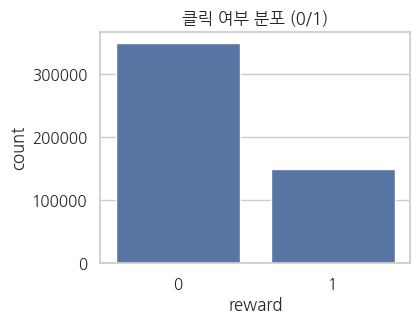


[ad_contents별 CTR/표본수]
    ad_contents       ctr       n
3            3  0.364290    3198
7            7  0.343763  142514
4            4  0.324849  102429
1            1  0.299013   50272
2            2  0.273402   37176
0            0  0.270495  103695
5            5  0.232954   27997
6            6  0.206464   31497


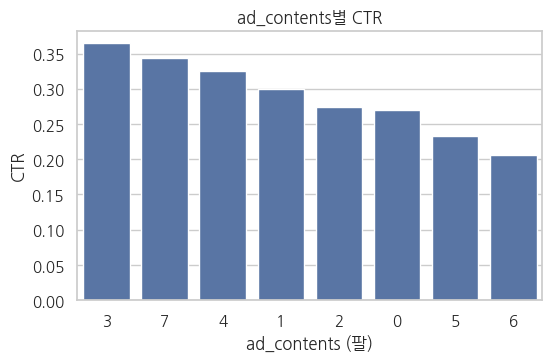

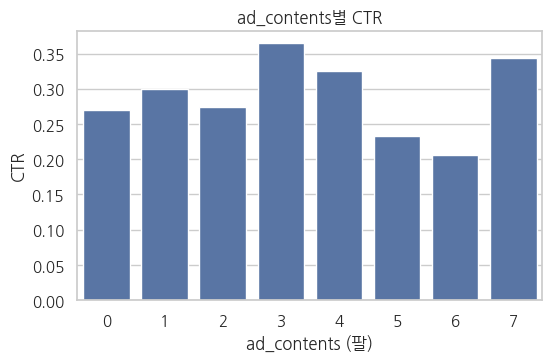


[요일별 CTR]
    day_of_week    reward
0            1  0.632039
1            2  0.685884
2            3  0.599835
3            4  0.130540
4            5  0.127331
5            6  0.635167
6            7  0.660157


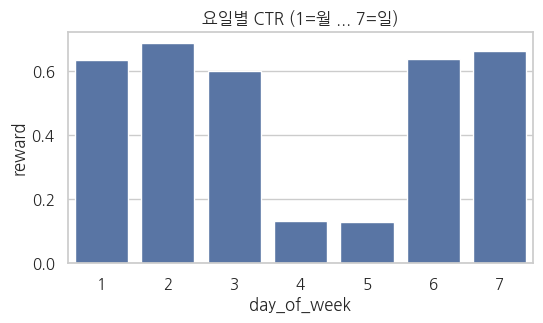


[시간별 CTR]
     hour    reward
0      0  0.302651
1      1  0.325652
2      2  0.354608
3      3  0.356013
4      4  0.321124
5      5  0.298447
6      6  0.282999
7      7  0.272244
8      8  0.278626
9      9  0.289323
10    10  0.278699
11    11  0.296858
12    12  0.293047
13    13  0.317360
14    14  0.312365
15    15  0.319442
16    16  0.316614
17    17  0.315415
18    18  0.313489
19    19  0.301297
20    20  0.298631
21    21  0.307351
22    22  0.297738
23    23  0.306965


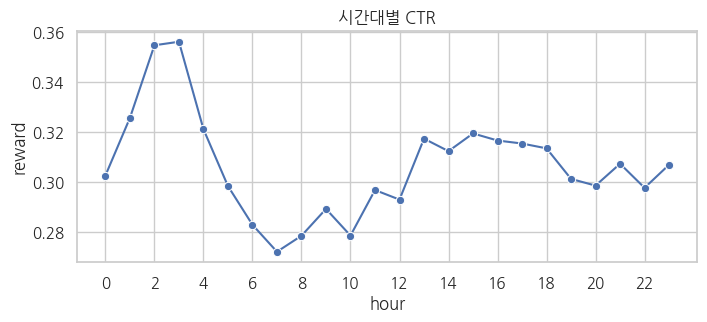

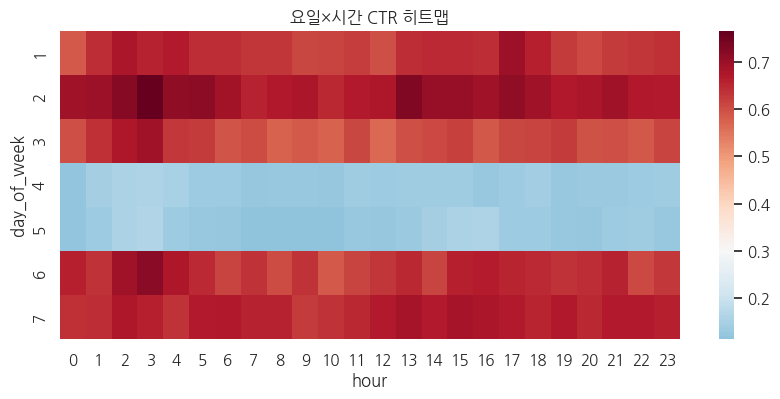


[성별 CTR]
    gender    reward
0     1.0  0.303691
1     2.0  0.293986


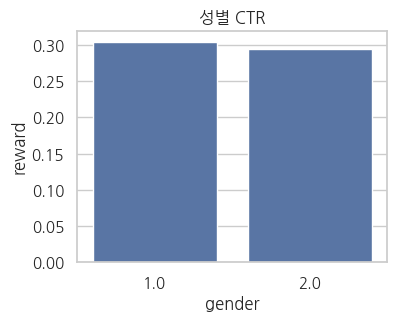


[연령대별 CTR]
    age_group    reward
0        1.0  0.630603
1        2.0  0.345361
2        3.0  0.306886
3        4.0  0.299139
4        5.0  0.285139
5        6.0  0.273571
6        7.0  0.282855
7        8.0  0.333123


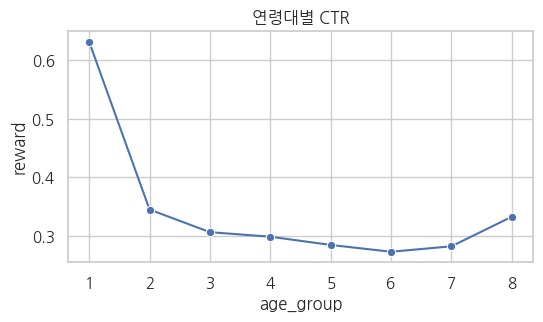


[inventory_id Top15 (표본수 기준 상위→ CTR 정렬)]
     inventory_id       ctr       n
10            41  0.463113   13677
14            88  0.462884   40373
15            91  0.448504    4544
8             37  0.399236   76411
6             31  0.346670   21095
11            42  0.340914   48543
5             29  0.321306   48807
9             39  0.301825    1534
13            46  0.282500   34892
3             19  0.278986    1104
12            43  0.264288   19615
7             36  0.243504   69120
2             11  0.203111   13052
0              2  0.161999  104717
1              8  0.136364     836


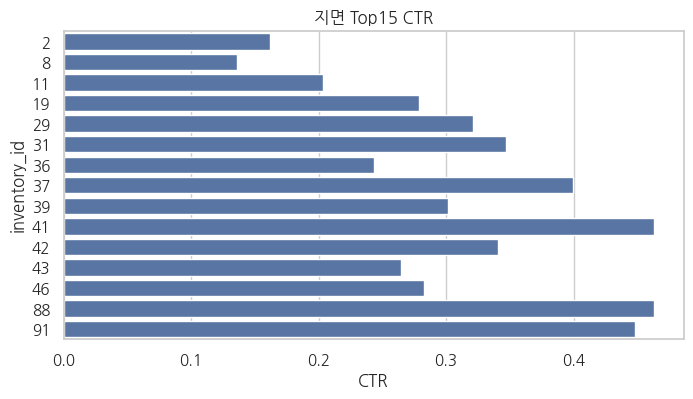


[seq_len 분위구간별 CTR]
        _seq_len_bin    reward
0     (0.999, 51.0]  0.454580
1     (51.0, 124.0]  0.347433
2    (124.0, 212.0]  0.311022
3    (212.0, 312.0]  0.295011
4    (312.0, 424.0]  0.285278
5    (424.0, 548.0]  0.277667
6    (548.0, 690.0]  0.263251
7    (690.0, 867.0]  0.260461
8   (867.0, 1126.0]  0.256052
9  (1126.0, 6590.0]  0.249634


/tmp/ipython-input-286121314.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_len = df.groupby("_seq_len_bin")["reward"].mean().reset_index()


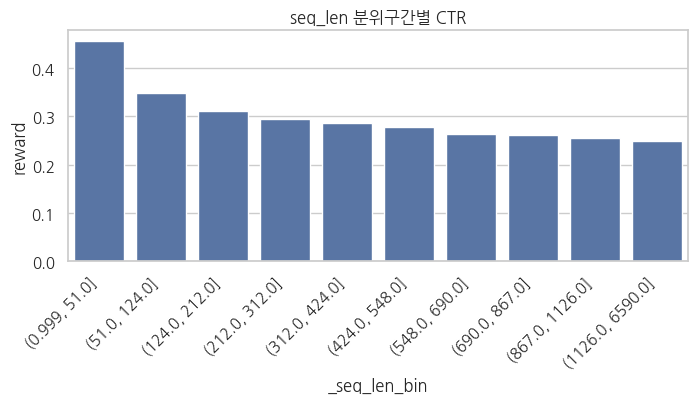


[seq_entropy 분위구간별 CTR]
                _seq_ent_bin    reward
0  (-0.001000000001, 2.476]  0.452474
1            (2.476, 2.951]  0.355739
2            (2.951, 3.148]  0.306468
3            (3.148, 3.251]  0.290495
4            (3.251, 3.325]  0.280424
5            (3.325, 3.388]  0.276034
6            (3.388, 3.448]  0.274996
7            (3.448, 3.511]  0.262901
8            (3.511, 3.592]  0.255423
9            (3.592, 4.242]  0.246361


/tmp/ipython-input-286121314.py:154: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_ent = df.groupby("_seq_ent_bin")["reward"].mean().reset_index()


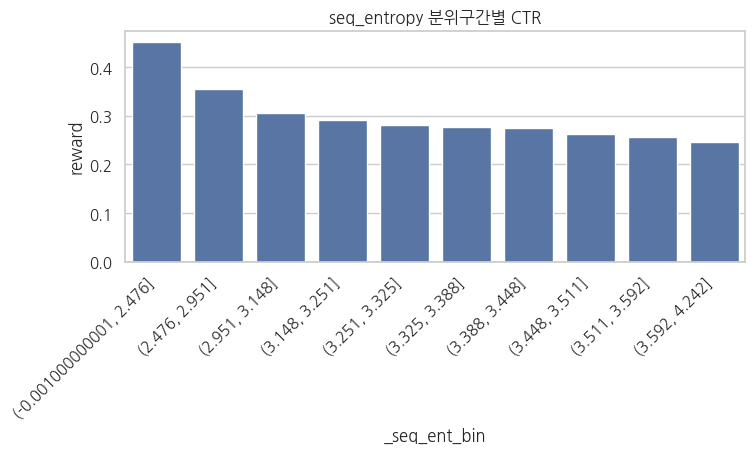


[seq_last 상위(표본수 기준) 20개 - CTR 정렬]
      seq_last       ctr       n
136       321  0.575847     679
63        144  0.546341    1230
77        177  0.489362     799
229       519  0.397539    6827
20         57  0.355531    1817
175       410  0.349794    1215
39         97  0.343387     862
227       516  0.331928     949
179       416  0.316896    1237
112       269  0.316147     737
13         35  0.301236  240728
57        132  0.294836    1065
208       479  0.291777  216515
239       532  0.281372    1283
72        165  0.280884     769
42        101  0.279628    4084
135       318  0.269641    2062
31         74  0.267442    1634
33         77  0.257373    3967
61        138  0.255072    1035


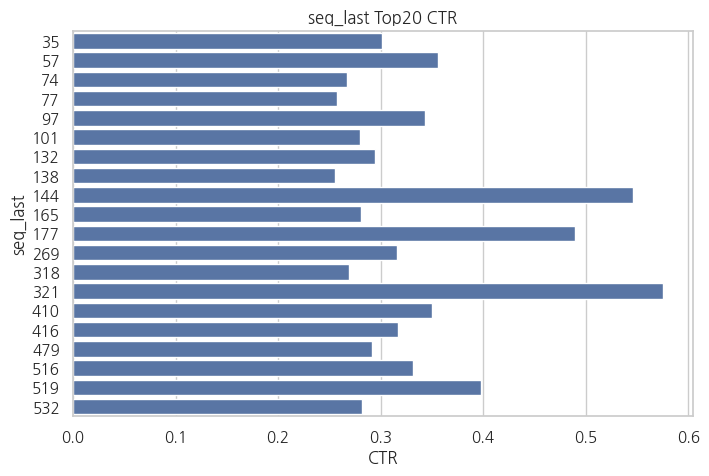


[요약]
- 전체 CTR: 0.3001
- ad_contents별 CTR 상위 5개:
   ad_contents       ctr       n
3            3  0.364290    3198
7            7  0.343763  142514
4            4  0.324849  102429
1            1  0.299013   50272
2            2  0.273402   37176
- 요일×시간 히트맵으로 시간 패턴 확인 완료.
- seq 파생과 CTR의 관계(길이/엔트로피/최근페이지) 확인 완료.


In [ ]:

import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------------------------
# 0) 로드 & 기본 점검
# -------------------------------------------------------------------
PATH = "data/Toss_preprocessed_FF.csv"
df = pd.read_csv(PATH)

print("파일 로드 완료:", df.shape)
print("컬럼:", df.columns.tolist())

# 타입/기초 정보
print("\n[INFO]")
print(df.info())

# 결측치 요약
print("\n[MISSING]")
miss = df.isnull().sum()
print(miss[miss>0].sort_values(ascending=False))

# reward 값 확인(0/1)
print("\n[reward 분포]")
print(df["reward"].value_counts(dropna=False))

# -------------------------------------------------------------------
# 1) 전체 CTR 및 기본 분포
# -------------------------------------------------------------------
ctr_all = df["reward"].mean()
print(f"\n✅ 전체 CTR: {ctr_all:.4f}")

plt.figure(figsize=(4,3))
sns.countplot(x="reward", data=df)
plt.title("클릭 여부 분포 (0/1)")
plt.show()

# -------------------------------------------------------------------
# 2) 팔(ad_contents)별 CTR
# -------------------------------------------------------------------


by_arm = (df.groupby("ad_contents")["reward"]
            .agg(ctr="mean", n="count")
            .reset_index()
            .sort_values(["ctr","n"], ascending=[False, False]))
print("\n[ad_contents별 CTR/표본수]\n", by_arm)

plt.figure(figsize=(6,3.5))
sns.barplot(x="ad_contents", y="ctr", data=by_arm, order=by_arm["ad_contents"])
plt.title("ad_contents별 CTR")
plt.xlabel("ad_contents (팔)")
plt.ylabel("CTR")
plt.show()


ordered_arms = sorted(by_arm["ad_contents"].unique(), key=lambda x: int(x))

plt.figure(figsize=(6,3.5))
# 2. barplot의 order 파라미터에 이 정렬된 리스트를 전달합니다.
sns.barplot(x="ad_contents", y="ctr", data=by_arm, order=ordered_arms)
plt.title("ad_contents별 CTR")
plt.xlabel("ad_contents (팔)")
plt.ylabel("CTR")
plt.show()


# -------------------------------------------------------------------
# 3) 시간 컨텍스트(요일/시간)별 CTR
# -------------------------------------------------------------------
# 요일별
if "day_of_week" in df.columns:
    by_dow = df.groupby("day_of_week")["reward"].mean().reset_index()
    print("\n[요일별 CTR]\n", by_dow)
    plt.figure(figsize=(6,3))
    sns.barplot(x="day_of_week", y="reward", data=by_dow)
    plt.title("요일별 CTR (1=월 ... 7=일)")
    plt.show()

# 시간별
if "hour" in df.columns:
    by_hour = df.groupby("hour")["reward"].mean().reset_index()
    print("\n[시간별 CTR]\n", by_hour)
    plt.figure(figsize=(8,3))
    sns.lineplot(x="hour", y="reward", data=by_hour, marker="o")
    plt.title("시간대별 CTR")
    plt.xticks(range(0,24,2))
    plt.show()

# 요일×시간 히트맵
if set(["day_of_week","hour"]).issubset(df.columns):
    pivot = df.pivot_table(index="day_of_week", columns="hour", values="reward", aggfunc="mean")
    plt.figure(figsize=(10,4))
    sns.heatmap(pivot, annot=False, cmap="RdBu_r", center=ctr_all)
    plt.title("요일×시간 CTR 히트맵")
    plt.show()

# -------------------------------------------------------------------
# 4) 성별·연령·지면별 CTR
# -------------------------------------------------------------------
# 성별
if "gender" in df.columns:
    by_gender = df.groupby("gender")["reward"].mean().reset_index()
    print("\n[성별 CTR]\n", by_gender)
    plt.figure(figsize=(4,3))
    sns.barplot(x="gender", y="reward", data=by_gender)
    plt.title("성별 CTR")
    plt.show()

# 연령대
if "age_group" in df.columns:
    by_age = df.groupby("age_group")["reward"].mean().reset_index()
    print("\n[연령대별 CTR]\n", by_age.head(20))
    plt.figure(figsize=(6,3))
    sns.lineplot(x="age_group", y="reward", data=by_age, marker="o")
    plt.title("연령대별 CTR")
    plt.show()

# 지면 TopN
TOPN = 15
if "inventory_id" in df.columns:
    top_inv = (df.groupby("inventory_id")["reward"]
                 .agg(ctr="mean", n="count")
                 .reset_index()
                 .sort_values("n", ascending=False)
                 .head(TOPN)
                 .sort_values("ctr", ascending=False))
    print(f"\n[inventory_id Top{TOPN} (표본수 기준 상위→ CTR 정렬)]\n", top_inv)

    plt.figure(figsize=(8,4))
    sns.barplot(y="inventory_id", x="ctr", data=top_inv, orient="h")
    plt.title(f"지면 Top{TOPN} CTR")
    plt.xlabel("CTR")
    plt.ylabel("inventory_id")
    plt.show()

# -------------------------------------------------------------------
# 5) seq 파생과 CTR의 관계
# -------------------------------------------------------------------
# seq_len 분위/구간화 → 구간별 CTR
if "seq_len" in df.columns:
    df["_seq_len_bin"] = pd.qcut(df["seq_len"], q=min(10, df["seq_len"].nunique()), duplicates="drop")
    by_len = df.groupby("_seq_len_bin")["reward"].mean().reset_index()
    print("\n[seq_len 분위구간별 CTR]\n", by_len.head(20))
    plt.figure(figsize=(8,3))
    sns.barplot(x="_seq_len_bin", y="reward", data=by_len)
    plt.xticks(rotation=45, ha="right")
    plt.title("seq_len 분위구간별 CTR")
    plt.show()

# seq_entropy 분위/구간화 → 구간별 CTR
if "seq_entropy" in df.columns:
    df["_seq_ent_bin"] = pd.qcut(df["seq_entropy"], q=min(10, df["seq_entropy"].nunique()), duplicates="drop")
    by_ent = df.groupby("_seq_ent_bin")["reward"].mean().reset_index()
    print("\n[seq_entropy 분위구간별 CTR]\n", by_ent.head(20))
    plt.figure(figsize=(8,3))
    sns.barplot(x="_seq_ent_bin", y="reward", data=by_ent)
    plt.xticks(rotation=45, ha="right")
    plt.title("seq_entropy 분위구간별 CTR")
    plt.show()

# seq_last 상위 카테고리(표본수 기준)만 보기
if "seq_last" in df.columns:
    top_last = (df.groupby("seq_last")["reward"]
                  .agg(ctr="mean", n="count")
                  .reset_index()
                  .sort_values("n", ascending=False)
                  .head(20)
                  .sort_values("ctr", ascending=False))
    print("\n[seq_last 상위(표본수 기준) 20개 - CTR 정렬]\n", top_last)

    plt.figure(figsize=(8,5))
    sns.barplot(y="seq_last", x="ctr", data=top_last, orient="h")
    plt.title("seq_last Top20 CTR")
    plt.xlabel("CTR")
    plt.ylabel("seq_last")
    plt.show()

# 정리 출력
print("\n[요약]")
print(f"- 전체 CTR: {ctr_all:.4f}")
print("- ad_contents별 CTR 상위 5개:")
print(by_arm.head(5))
if "hour" in df and "day_of_week" in df:
    print("- 요일×시간 히트맵으로 시간 패턴 확인 완료.")
print("- seq 파생과 CTR의 관계(길이/엔트로피/최근페이지) 확인 완료.")

# (선택) 임시 컬럼 삭제
for c in ["_seq_len_bin","_seq_ent_bin"]:
    if c in df.columns:
        del df[c]
